In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta, time

In [2]:
area_path = '../dataset/area_timing/'
path_to_facility= '../dataset/facility_timing/'

In [3]:
sat_name = '112004'

In [12]:
# Read visibility to facilites data
dfs = []
for path, subdirs, files in os.walk(path_to_facility):
    for name in files:
        if sat_name in name:
            facility_csv_path = os.path.join(path, name)
            df = pd.read_csv(facility_csv_path, index_col=0)
            df['Start Time (UTCG)'] = pd.to_datetime(df['Start Time (UTCG)'], format='%d %b %Y %H:%M:%S.%f')
            df['Stop Time (UTCG)'] = pd.to_datetime(df['Stop Time (UTCG)'], format='%d %b %Y %H:%M:%S.%f')
            df['facility'] = name.split('-To-')[0]
            df['sat_name'] = sat_name
            mask = (df['Start Time (UTCG)'].dt.time >= time(7,30,00)) & (df['Start Time (UTCG)'].dt.time <= time(19,30,00))
            df_working = df.loc[mask]
            dfs.append(df_working)

facilities_df = pd.concat(dfs)

In [13]:
# Read area data
dfs = []
for path, subdirs, files in os.walk(area_path):
    for name in files:
        if sat_name in name:
            area_csv_path = os.path.join(path, name)
            df = pd.read_csv(area_csv_path, index_col=0)
            df['Start Time (UTCG)'] = pd.to_datetime(df['Start Time (UTCG)'], format='%d %b %Y %H:%M:%S.%f')
            df['Stop Time (UTCG)'] = pd.to_datetime(df['Stop Time (UTCG)'], format='%d %b %Y %H:%M:%S.%f')
            df['sat_name'] = sat_name
            mask = (df['Start Time (UTCG)'].dt.time >= time(9,00,00)) & (df['Start Time (UTCG)'].dt.time <= time(18,00,00))
            df_working = df.loc[mask]
            dfs.append(df_working)

area_df = pd.concat(dfs)

In [15]:
area_df = area_df.sort_values(by=['Start Time (UTCG)'])
area_df.reset_index(inplace=True, drop=True)

facilities_df = facilities_df.sort_values(by=['Start Time (UTCG)'])
facilities_df.reset_index(inplace=True, drop=True)

In [16]:
facilities_df

,Start Time (UTCG),Stop Time (UTCG),Duration (sec),facility,sat_name
0,2027-06-01 07:40:28.436,2027-06-01 07:53:25.008,776.572,Anadyr2,112004
1,2027-06-01 07:40:28.436,2027-06-01 07:53:25.008,776.572,Anadyr1,112004
2,2027-06-01 07:41:59.187,2027-06-01 07:52:56.758,657.571,Magadan1,112004
3,2027-06-01 07:41:59.187,2027-06-01 07:52:56.758,657.571,Magadan2,112004
4,2027-06-01 07:49:20.498,2027-06-01 08:00:12.703,652.205,Norilsk,112004
...,...,...,...,...,...
757,2027-06-13 18:11:11.337,2027-06-13 18:23:42.197,750.860,Murmansk1,112004
758,2027-06-13 18:11:11.337,2027-06-13 18:23:42.197,750.860,Murmansk2,112004
759,2027-06-13 18:26:19.342,2027-06-13 18:33:22.528,423.187,Anadyr1,112004
760,2027-06-13 18:26:19.342,2027-06-13 18:33:22.528,423.187,Anadyr2,112004


In [17]:
area_df

,Start Time (UTCG),Stop Time (UTCG),Duration (sec),sat_name
0,2027-06-01 09:20:18.412,2027-06-01 09:26:23.133,364.722,112004
1,2027-06-01 10:55:10.886,2027-06-01 11:03:25.508,494.622,112004
2,2027-06-01 11:03:45.889,2027-06-01 11:04:44.099,58.210,112004
3,2027-06-01 12:33:16.259,2027-06-01 12:40:43.011,446.751,112004
4,2027-06-01 14:10:09.575,2027-06-01 14:15:21.132,311.557,112004
...,...,...,...,...
92,2027-06-13 11:46:08.494,2027-06-13 11:53:02.958,414.464,112004
93,2027-06-13 13:22:19.004,2027-06-13 13:28:39.405,380.401,112004
94,2027-06-13 15:00:18.232,2027-06-13 15:04:43.633,265.401,112004
95,2027-06-13 16:36:08.901,2027-06-13 16:40:23.876,254.976,112004


In [18]:
filtered_facilities_df = facilities_df.copy()

for _, area_row in area_df.iterrows():
    cut_start = area_row['Start Time (UTCG)']
    cut_stop = area_row['Stop Time (UTCG)']
    new_df = pd.DataFrame(columns=filtered_facilities_df.columns)
    for index, facility_row in filtered_facilities_df.iterrows():
        start_time_facility = facility_row['Start Time (UTCG)']
        stop_time_facility = facility_row['Stop Time (UTCG)']
        if max(cut_start, start_time_facility) < min(cut_stop, stop_time_facility):
            alt_row = facility_row.copy()
            if start_time_facility < cut_start:
                facility_row['Stop Time (UTCG)'] = cut_start
                new_df = pd.concat([new_df, facility_row.to_frame(1).T], ignore_index=True)
            if stop_time_facility > cut_stop:
                alt_row['Start Time (UTCG)'] = cut_stop
                new_df = pd.concat([new_df, alt_row.to_frame(1).T], ignore_index=True)
        else:
            new_df = pd.concat([new_df, facility_row.to_frame(1).T], ignore_index=True)
    filtered_facilities_df = new_df.copy()

In [105]:
filtered_facilities_df

,Start Time (UTCG),Stop Time (UTCG),Duration (sec),facility,sat_name
0,2027-06-01 07:40:28.436,2027-06-01 07:53:25.008,776.572,Anadyr2,112004
1,2027-06-01 07:40:28.436,2027-06-01 07:53:25.008,776.572,Anadyr1,112004
2,2027-06-01 07:41:59.187,2027-06-01 07:52:56.758,657.571,Magadan1,112004
3,2027-06-01 07:41:59.187,2027-06-01 07:52:56.758,657.571,Magadan2,112004
4,2027-06-01 07:49:20.498,2027-06-01 08:00:12.703,652.205,Norilsk,112004
...,...,...,...,...,...
1098,2027-06-13 18:11:11.337,2027-06-13 18:23:42.197,750.86,Murmansk1,112004
1099,2027-06-13 18:11:11.337,2027-06-13 18:23:42.197,750.86,Murmansk2,112004
1100,2027-06-13 18:26:19.342,2027-06-13 18:33:22.528,423.187,Anadyr1,112004
1101,2027-06-13 18:26:19.342,2027-06-13 18:33:22.528,423.187,Anadyr2,112004


In [85]:
area_df

,Start Time (UTCG),Stop Time (UTCG),Duration (sec),sat_name
0,2027-06-01 09:46:51.002,2027-06-01 09:52:36.364,345.363,111603
1,2027-06-01 09:52:37.524,2027-06-01 09:53:38.951,61.427,111603
2,2027-06-01 11:23:11.938,2027-06-01 11:29:33.792,381.854,111603
3,2027-06-01 13:00:45.544,2027-06-01 13:05:07.811,262.268,111603
4,2027-06-01 14:36:49.173,2027-06-01 14:41:00.961,251.788,111603
...,...,...,...,...
75,2027-06-13 12:11:33.065,2027-06-13 12:16:47.503,314.437,111603
76,2027-06-13 12:16:50.059,2027-06-13 12:17:47.806,57.747,111603
77,2027-06-13 12:17:51.974,2027-06-13 12:18:10.510,18.536,111603
78,2027-06-13 13:49:36.192,2027-06-13 13:53:45.861,249.668,111603


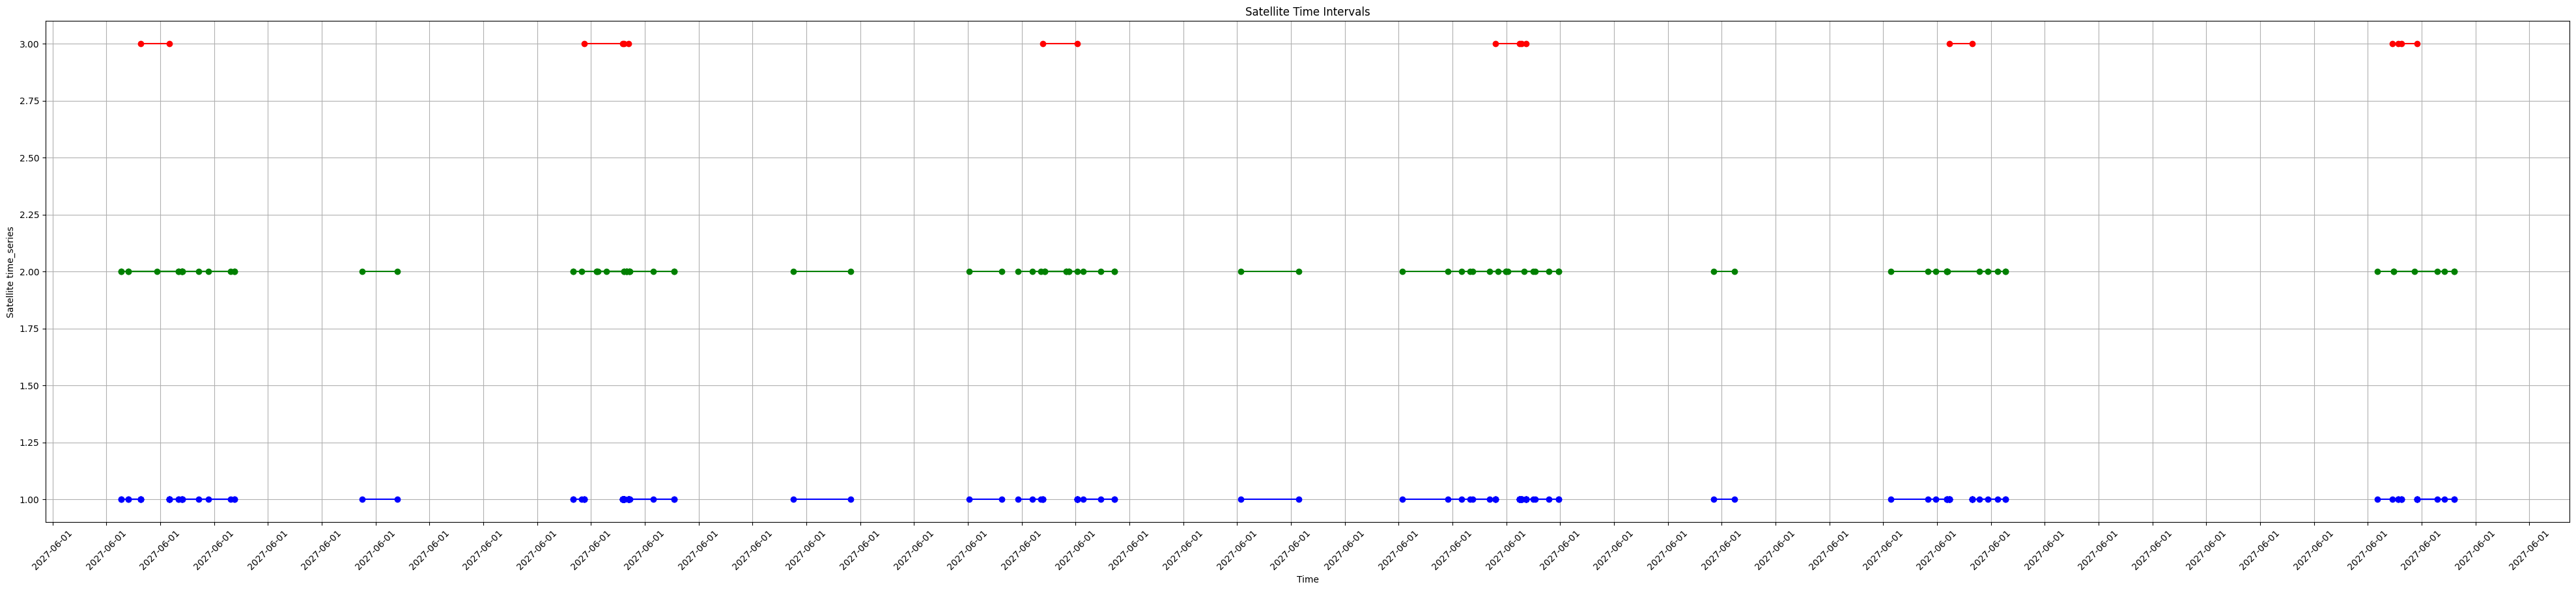

In [19]:
# Set the figure size
plt.figure(figsize=(50, 10))

facility_name = 'Moscow'

# Plot the time intervals as a line plot with unique colors
for i, row in area_df.iterrows():
    sat_name = 3
    plt.plot([row['Start Time (UTCG)'], row['Stop Time (UTCG)']], [sat_name, sat_name], marker='o', color='r')

for i, row in facilities_df.iterrows():
    sat_name = 2
    # if row['facility'] == facility_name:
    plt.plot([row['Start Time (UTCG)'], row['Stop Time (UTCG)']], [sat_name, sat_name], marker='o', color='g')

for i, row in filtered_facilities_df.iterrows():
    sat_name = 1
    # if row['facility'] == facility_name:
    plt.plot([row['Start Time (UTCG)'], row['Stop Time (UTCG)']], [sat_name, sat_name], marker='o', color='b')

# Set the y-axis labels as satellite names

# Set x-axis and y-axis labels
plt.xlabel('Time')
plt.ylabel('Satellite time_series')

# Set the title of the plot
plt.title('Satellite Time Intervals')

# Increase tick rate on x-axis
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))

plt.xlim([datetime(2027, 6, 1, 9, 0, 0), datetime(2027, 6, 1, 18, 0, 0)])
plt.grid()
# Display the plot
plt.show()